In [20]:
# --- Notebook : Modèle Linéaire - Cas de Tests de Régression ---
import ctypes
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [21]:
# === Chargement de la bibliothèque Rust compilée ===
lib = ctypes.CDLL("../../../target/release/mymodel.dll")

In [23]:
# Déclaration des fonctions externes (FFI)
lib.create_softmax_model.argtypes = [
    ctypes.c_size_t, ctypes.c_size_t, ctypes.c_double, ctypes.c_size_t, ctypes.c_double
]
lib.create_softmax_model.restype = ctypes.c_void_p

lib.train_softmax_model.argtypes = [
    ctypes.c_void_p,
    ctypes.POINTER(ctypes.c_double),
    ctypes.POINTER(ctypes.c_size_t),
    ctypes.c_size_t,
    ctypes.c_size_t
]
lib.train_softmax_model.restype = None

lib.predict_softmax_model.argtypes = [
    ctypes.c_void_p,
    ctypes.POINTER(ctypes.c_double),
    ctypes.c_size_t
]
lib.predict_softmax_model.restype = ctypes.c_size_t

### Multi Linear 3 classes :
        Linear Model x3 : OK

Softmax accuracy: 50.12%


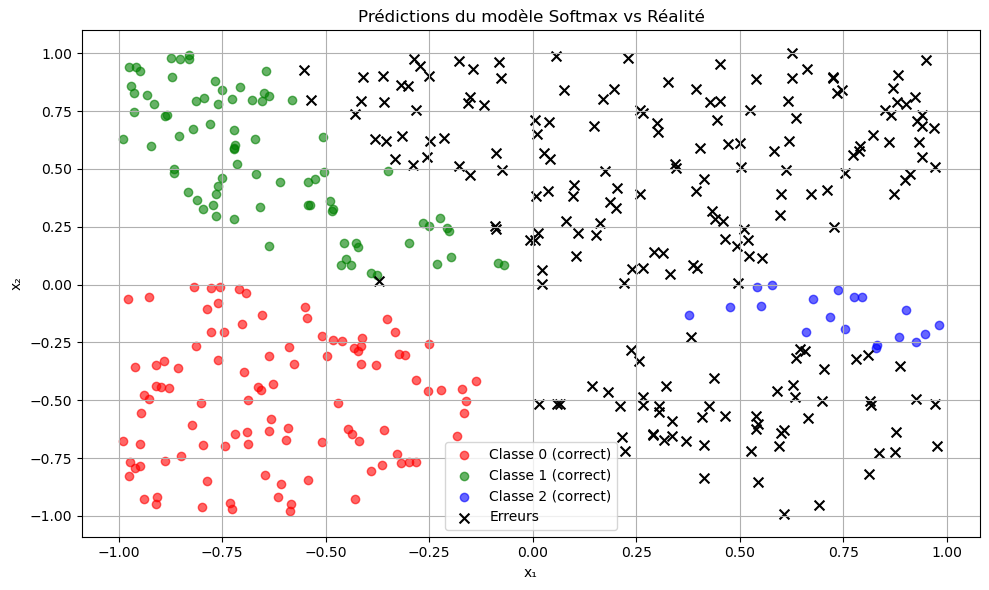

In [29]:
# === Données ===
np.random.seed(42)
X = np.random.random((500, 2)) * 2.0 - 1.0
Y = np.array([
    [1, 0, 0] if -p[0] - p[1] - 0.5 > 0 and p[1] < 0 and p[0] - p[1] - 0.5 < 0 else
    [0, 1, 0] if -p[0] - p[1] - 0.5 < 0 and p[1] > 0 and p[0] - p[1] - 0.5 < 0 else
    [0, 0, 1] if -p[0] - p[1] - 0.5 < 0 and p[1] < 0 and p[0] - p[1] - 0.5 > 0 else
    [0, 0, 0] for p in X
])


mask = ~np.all(Y == [0, 0, 0], axis=1)
X = X[mask]
Y = Y[mask]

y_labels = np.argmax(Y, axis=1).astype(np.uint32)
n_samples, n_features = X.shape
n_classes = 3

# === Modèle ===
lambda_l2 = 0.01
model = lib.create_softmax_model(n_features, n_classes, 0.01, 3000, lambda_l2)

x_ptr = X.astype(np.float64).flatten().ctypes.data_as(ctypes.POINTER(ctypes.c_double))
y_ptr = y_labels.ctypes.data_as(ctypes.POINTER(ctypes.c_uint))


# === Prédiction ===
y_pred = np.array([
    lib.predict_softmax_model(
        model,
        x.astype(np.float64).ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        n_features
    ) for x in X
])

# === Affichage ===
accuracy = np.mean(y_pred == y_labels)
print(f"Softmax accuracy: {accuracy * 100:.2f}%")

colors = ["red", "green", "blue"]
labels = ["Classe 0", "Classe 1", "Classe 2"]
errors = y_pred != y_labels

plt.figure(figsize=(10, 6))
for k in range(n_classes):
    mask = (y_labels == k) & (~errors)
    plt.scatter(X[mask, 0], X[mask, 1], label=f"{labels[k]} (correct)", color=colors[k], alpha=0.6)

plt.scatter(X[errors, 0], X[errors, 1], color='black', marker='x', label="Erreurs", s=50)

plt.title("Prédictions du modèle Softmax vs Réalité")
plt.xlabel("x₁")
plt.ylabel("x₂")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Exemple avec un dataset fixe linéairement séparable

Softmax accuracy: 100.00%


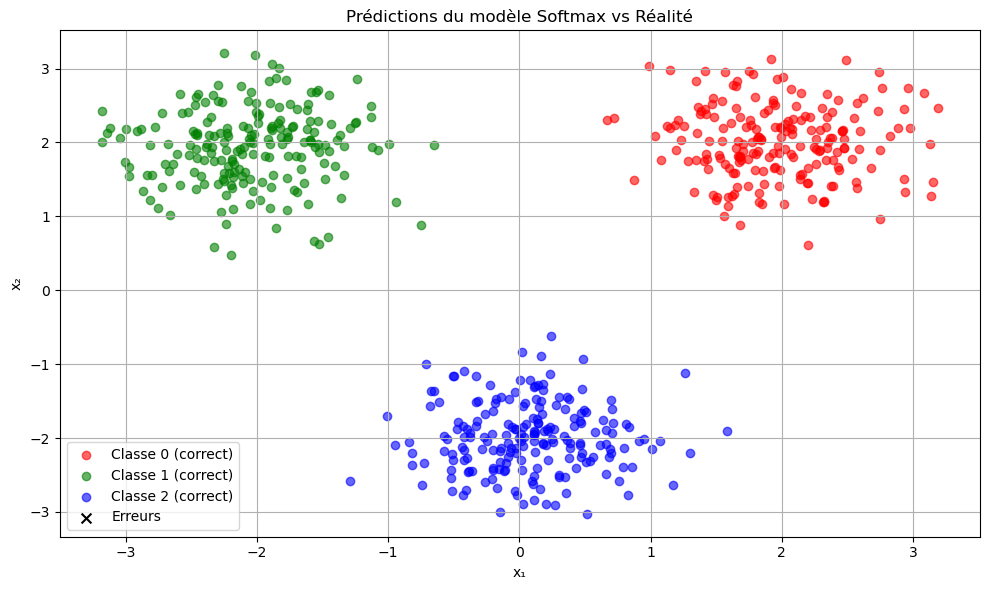

In [31]:
# ========= 2) Génération d’un dataset linéairement séparable =========
np.random.seed(0)

centers = np.array([[ 2.0,  2.0],   # Classe 0
                    [-2.0,  2.0],   # Classe 1
                    [ 0.0, -2.0]])  # Classe 2

samples_per_class = 200
X_parts, y_parts = [], []

for idx, c in enumerate(centers):
    X_parts.append(0.5 * np.random.randn(samples_per_class, 2) + c)
    y_parts.append(np.full(samples_per_class, idx, dtype=np.uintp))

X = np.vstack(X_parts)
y_labels = np.hstack(y_parts)             # labels entiers 0,1,2 (dtype np.uintp)
n_samples, n_features = X.shape
n_classes = 3

# ========= 3) Création + entraînement du modèle =========
lambda_l2 = 0.0        # inutile ici, pas de surapprentissage sur un petit jeu
learning_rate = 0.1
epochs = 1000

model = lib.create_softmax_model(n_features, n_classes,
                                 learning_rate, epochs, lambda_l2)

x_ptr = X.astype(np.float64).ravel().ctypes.data_as(ctypes.POINTER(ctypes.c_double))
y_ptr = y_labels.ctypes.data_as(ctypes.POINTER(ctypes.c_size_t))

lib.train_softmax_model(model, x_ptr, y_ptr, n_samples, n_features)

# === Prédiction ===
y_pred = np.array([
    lib.predict_softmax_model(
        model,
        x.astype(np.float64).ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        n_features
    ) for x in X
])

# === Affichage ===
accuracy = np.mean(y_pred == y_labels)
print(f"Softmax accuracy: {accuracy * 100:.2f}%")

colors = ["red", "green", "blue"]
labels = ["Classe 0", "Classe 1", "Classe 2"]
errors = y_pred != y_labels

plt.figure(figsize=(10, 6))
for k in range(n_classes):
    mask = (y_labels == k) & (~errors)
    plt.scatter(X[mask, 0], X[mask, 1], label=f"{labels[k]} (correct)", color=colors[k], alpha=0.6)

plt.scatter(X[errors, 0], X[errors, 1], color='black', marker='x', label="Erreurs", s=50)

plt.title("Prédictions du modèle Softmax vs Réalité")
plt.xlabel("x₁")
plt.ylabel("x₂")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# ### Multi Cross :


>> Entraînement
Softmax accuracy: 52.40%


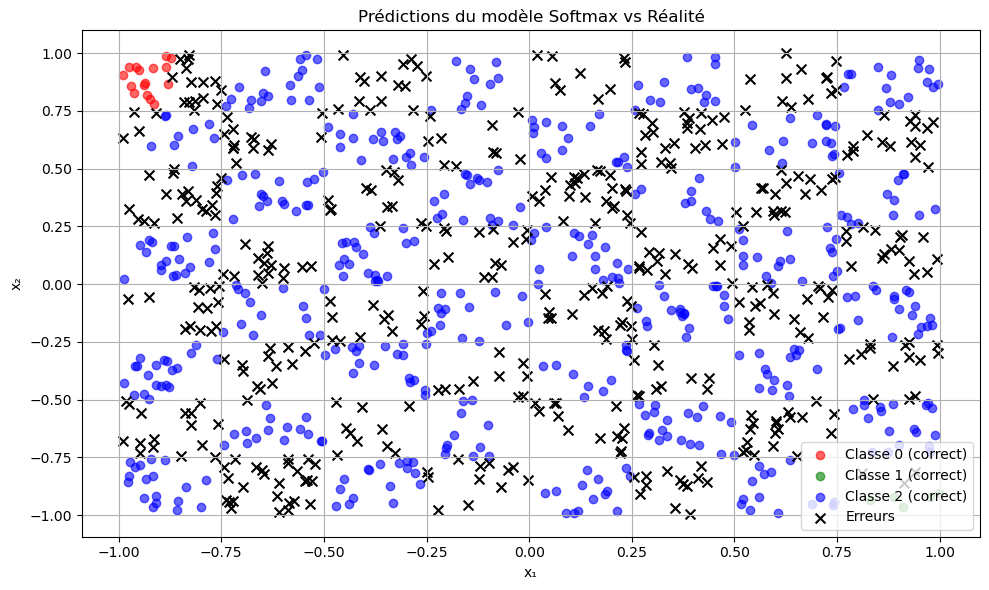

In [34]:
# === Données ===
np.random.seed(42)
X = np.random.random((1000, 2)) * 2.0 - 1.0

Y = np.array([
    [1, 0, 0] if abs(p[0] % 0.5) <= 0.25 and abs(p[1] % 0.5) > 0.25 else
    [0, 1, 0] if abs(p[0] % 0.5) > 0.25 and abs(p[1] % 0.5) <= 0.25 else
    [0, 0, 1]
    for p in X
])

y_labels = np.argmax(Y, axis=1).astype(np.uintp)

n_samples, n_features = X.shape
n_classes = 3

# === Modèle ===
lambda_l2 = 0.0
learning_rate = 0.1
epochs = 1000

model = lib.create_softmax_model(n_features, n_classes,
                                 learning_rate, epochs, lambda_l2)

x_ptr = X.astype(np.float64).ravel().ctypes.data_as(ctypes.POINTER(ctypes.c_double))
y_ptr = y_labels.ctypes.data_as(ctypes.POINTER(ctypes.c_size_t))

print(">> Entraînement")
lib.train_softmax_model(model, x_ptr, y_ptr, n_samples, n_features)

# === Prédiction ===
y_pred = np.array([
    lib.predict_softmax_model(
        model,
        x.astype(np.float64).ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        n_features
    ) for x in X
])

# === Affichage ===
accuracy = np.mean(y_pred == y_labels)
print(f"Softmax accuracy: {accuracy * 100:.2f}%")

colors = ["red", "green", "blue"]
labels = ["Classe 0", "Classe 1", "Classe 2"]
errors = y_pred != y_labels

plt.figure(figsize=(10, 6))
for k in range(n_classes):
    mask = (y_labels == k) & (~errors)
    plt.scatter(X[mask, 0], X[mask, 1], label=f"{labels[k]} (correct)", color=colors[k], alpha=0.6)

plt.scatter(X[errors, 0], X[errors, 1], color='black', marker='x', label="Erreurs", s=50)

plt.title("Prédictions du modèle Softmax vs Réalité")
plt.xlabel("x₁")
plt.ylabel("x₂")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()